### The goal of this notebook is to display photos
(In whatever form)

Of 100 mergers from TNG100.

Since there are available images at z = 0.05, this could be a good place to search.

Since there isn't a next progenitor pointer in the normal snapshot files, you'll have to use the merger trees.
And it would be great if you could use the same architecture as TNG50 so that it could transfer over better.



In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"3b865713af85f5da0dba3b577e289484"}
def get(path, params=None):
    # make HTTP GET request to path
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

In [85]:
r = get(baseUrl)
names = [sim['name'] for sim in r['simulations']]
i = names.index('TNG100-1')
sim = get( r['simulations'][i]['url'] )
snaps = get( sim['snapshots'] )
snap = get( snaps[-1]['url'] )

snap_98 = get( snaps[-2]['url'] )
subs = get( snap['subhalos'], {'limit':2000, 'order_by':'-mass_stars'} )#was 20


# Okay so try to sort this by query
# Snyder sorts for M_stellar > 10^10.5
mass_min = 10**10.5 / 1e10 * 0.704
mass_max = 10**11 / 1e10 * 0.704
search_query = "?mass_stars__gt=" + str(mass_min) + "&mass_stars__lt=" + str(mass_max)
print(search_query)
query_url = "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/" + search_query
query_subhalos = get(query_url)
print('Number of subhalos', query_subhalos['count'])

'''
num=1000
sub = get( subs['results'][num]['url'] )#was 1
print(sub.keys())
'''

?mass_stars__gt=2.2262434727585387&mass_stars__lt=7.039999999999999
Number of subhalos 2095


"num=1000\nsub = get( subs['results'][num]['url'] )#was 1\nprint(sub.keys())"

In [103]:
# Now, search through all of these subhalos for mergers
mass_stars=[]
sfr=[]
id_list=[]
mass_total=[]
for i in range(query_subhalos['count']):
    # So for each subhalo
    try:
        sub = get( query_subhalos['results'][i]['url'] )
    except:
        print('ending here', i)
        break
    mass_stars.append(sub['mass_stars'])
    mass_total.append(sub['mass'])
    sfr.append(sub['sfr'])
    id_list.append(sub['id'])
    
    sub_desc = sub
    
    # Then use the simple query
    url_json = sub['trees']['sublink_simple']
    tree_simple = get(url_json)
    print('number of merger supposedly', len(tree_simple['Mergers']), 'for this id', sub['id'])
    # So make something that will hold all mergers at this point in time
    merger_98 = []
    for j in range(len(tree_simple['Mergers'])):
        #print(tree_simple['Mergers'][j][0])
        if tree_simple['Mergers'][j][0] ==98:

            # Look through and see if any has a stellar mass that's near to the descendant
            sub_prog_url = "http://www.tng-project.org/api/TNG100-1/snapshots/98/subhalos/"+str(tree_simple['Mergers'][j][1])+"/"
            sub_prog = get(sub_prog_url)

            ending_mass = sub_prog['mass_stars']
            prog_mass_list = []
            prog_snapnum_list = []
            if sub_prog['mass_stars']==0.0:
                continue

            prog_mass_list.append(sub_prog['mass_stars'])
            prog_snapnum_list.append(sub_prog['snap'])
            while sub_prog['related']['sublink_progenitor'] != 'None':
                try:
                    mpb_prog = get(sub_prog['related']['sublink_progenitor'])
                except:
                    break
                prog_mass_list.append(mpb_prog['mass_stars'])
                prog_snapnum_list.append(mpb_prog['snap'])
                #print('snapshot walkin ',mpb_prog['snap'], ' stellar mass', mpb_prog['mass_stars'])
                sub_prog = mpb_prog
                if mpb_prog['snap'] < 98-5:
                    break

            '''plt.clf()
            plt.plot(prog_snapnum_list, prog_mass_list)
            plt.show()'''

            max_mass_history = max(prog_mass_list)
            print('subfind id', tree_simple['Mergers'][j])
            #print('max mass', max_mass_history)
            print('mass ratio', max_mass_history/sub_desc['mass_stars'])
            # Note that there is an option to load a main progenitor mass brach if you want to load a mass history.
            if max_mass_history > 0.1*sub_desc['mass_stars']:# basically if its within 10%
                merger_98.append(tree_simple['Mergers'][j][1])
                print('found another', sub_prog['mass_stars'], tree_simple['Mergers'][j][1])
        if len(merger_98) > 0:
            print('merger 98', merger_98, 'one subhalo', sub['id'])
        



number of merger supposedly 400 for this id 12
number of merger supposedly 578 for this id 13
number of merger supposedly 277 for this id 15
number of merger supposedly 589 for this id 16
number of merger supposedly 879 for this id 17
number of merger supposedly 251 for this id 18
number of merger supposedly 198 for this id 20
subfind id [98, 614]
mass ratio 0.02689004650777945
subfind id [98, 2852]
mass ratio 0.0009732502697727015
number of merger supposedly 242 for this id 22
number of merger supposedly 240 for this id 25
number of merger supposedly 147 for this id 26
number of merger supposedly 199 for this id 27
subfind id [98, 534]
mass ratio 0.03588978600718438
number of merger supposedly 211 for this id 28
number of merger supposedly 181 for this id 30
number of merger supposedly 295 for this id 31
number of merger supposedly 183 for this id 32
number of merger supposedly 180 for this id 33
number of merger supposedly 325 for this id 34
number of merger supposedly 157 for this i

n points 100
[0.0, 0.0, 0.0130215, 0.0, 0.0583733, 0.0174699, 0.461354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.451621, 0.0, 0.0, 0.0, 7.76206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00734263, 0.0, 0.000519468, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.57396, 0.0, 0.0, 1.672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0580418, 0.0, 0.55751, 0.0, 0.0120872, 0.0, 0.0, 2.36634, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.808439, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0305612, 0.0268847, 0.0, 4.12298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.01544]


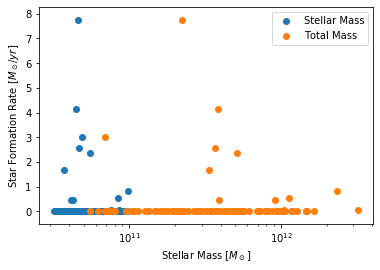

In [97]:
scaled_mass = [x* 1e10 / 0.704 for x in mass_stars]
scaled_mass_total = [x* 1e10 / 0.704 for x in mass_total]
print('n points', len(scaled_mass))

print(sfr)

plt.clf()
plt.scatter(scaled_mass, sfr, label='Stellar Mass')
plt.scatter(scaled_mass_total, sfr, label='Total Mass')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel('Stellar Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')
plt.show()

In [71]:
print(sub['trees'].keys())

dict_keys(['sublink', 'sublink_mpb', 'sublink_mdb', 'sublink_simple', 'lhalotree', 'lhalotree_mpb'])


In [72]:
print(len(sub['trees']['sublink_simple']))

88


In [73]:
print(sub['trees']['sublink_simple'])

http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/435782/sublink/simple.json


In [74]:
url_json = sub['trees']['sublink_simple']
tree_simple = get(url_json)
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType']


print(len(tree_simple['Mergers']))# This is the number of mergers in the merger tree


455


In [75]:
# Get the information for the descendant subhalo we're talking about and get a pic of it:
id_desc = subs['results'][num]['id']
print('id descendent', id_desc)

sub_desc_url = "http://www.tng-project.org/api/TNG100-1/snapshots/99/subhalos/"+str(id_desc)+"/"
sub_desc = get(sub_desc_url)
#get(sub_desc['vis']['galaxy_stellar_light'])
print('Stellar mass descendant', sub_desc['mass_stars'])


id descendent 435782
Stellar mass descendant 5.21982


In [76]:
# Now search through and see if it merges in the last snapshot
merger_98 = []
for j in range(len(tree_simple['Mergers'])):
    #print(tree_simple['Mergers'][j][0])
    if tree_simple['Mergers'][j][0] ==98:
        
        # Look through and see if any has a stellar mass that's near to the descendant
        sub_prog_url = "http://www.tng-project.org/api/TNG100-1/snapshots/98/subhalos/"+str(tree_simple['Mergers'][j][1])+"/"
        sub_prog = get(sub_prog_url)
        
        ending_mass = sub_prog['mass_stars']
        prog_mass_list = []
        prog_snapnum_list = []
        if sub_prog['mass_stars']==0.0:
            continue
        
        prog_mass_list.append(sub_prog['mass_stars'])
        prog_snapnum_list.append(sub_prog['snap'])
        while sub_prog['related']['sublink_progenitor'] != 'None':
            try:
                mpb_prog = get(sub_prog['related']['sublink_progenitor'])
            except:
                break
            prog_mass_list.append(mpb_prog['mass_stars'])
            prog_snapnum_list.append(mpb_prog['snap'])
            #print('snapshot walkin ',mpb_prog['snap'], ' stellar mass', mpb_prog['mass_stars'])
            sub_prog = mpb_prog
            if mpb_prog['snap'] < 98-5:
                break
            
        '''plt.clf()
        plt.plot(prog_snapnum_list, prog_mass_list)
        plt.show()'''
        
        max_mass_history = max(prog_mass_list)
        print('subfind id', tree_simple['Mergers'][j])
        #print('max mass', max_mass_history)
        print('mass ratio', max_mass_history/sub_desc['mass_stars'])
        # Note that there is an option to load a main progenitor mass brach if you want to load a mass history.
        if max_mass_history > 0.1*sub_desc['mass_stars']:# basically if its within 10%
            merger_98.append(tree_simple['Mergers'][j][1])
            print('found another', sub_prog['mass_stars'], tree_simple['Mergers'][j][1])
    
    '''if gal > 5:
        break
    if tree_simple['Mergers'][j][0] ==snapnumber:'''
print(len(merger_98))
# How is merger defined here?

subfind id [98, 434443]
mass ratio 0.0012084707901805043
0


In [31]:
sub_prog_url = "http://www.tng-project.org/api/TNG100-1/snapshots/98/subhalos/"+str(merger_98[0])+"/"
sub_prog = get(sub_prog_url)
print(sub_prog.keys())
print('Stellar mass progenitor', sub_prog['mass_stars'])

#get(sub_prog['vis']['galaxy_stellar_light'])




dict_keys(['snap', 'id', 'bhmdot', 'cm_x', 'cm_y', 'cm_z', 'gasmetallicity', 'gasmetallicityhalfrad', 'gasmetallicitymaxrad', 'gasmetallicitysfr', 'gasmetallicitysfrweighted', 'pos_x', 'pos_y', 'pos_z', 'halfmassrad', 'halfmassrad_gas', 'halfmassrad_dm', 'halfmassrad_stars', 'halfmassrad_bhs', 'len', 'len_gas', 'len_dm', 'len_stars', 'len_bhs', 'mass', 'mass_gas', 'mass_dm', 'mass_stars', 'mass_bhs', 'massinhalfrad', 'massinhalfrad_gas', 'massinhalfrad_dm', 'massinhalfrad_stars', 'massinhalfrad_bhs', 'massinmaxrad', 'massinmaxrad_gas', 'massinmaxrad_dm', 'massinmaxrad_stars', 'massinmaxrad_bhs', 'massinrad', 'massinrad_gas', 'massinrad_dm', 'massinrad_stars', 'massinrad_bhs', 'sfr', 'sfrinhalfrad', 'sfrinmaxrad', 'sfrinrad', 'spin_x', 'spin_y', 'spin_z', 'starmetallicity', 'starmetallicityhalfrad', 'starmetallicitymaxrad', 'stellarphotometrics_u', 'stellarphotometrics_b', 'stellarphotometrics_v', 'stellarphotometrics_k', 'stellarphotometrics_g', 'stellarphotometrics_r', 'stellarphotome

In [21]:
cutout_request = {'gas':'Coordinates,Masses'}
cutout = get(sub_prog_url+"cutout.hdf5", cutout_request)

In [27]:
import h5py



sub_prog_url = "http://www.tng-project.org/api/TNG100-1/snapshots/98/subhalos/" + str(merger_98[0])
sub_prog = get(sub_prog_url)

cutout = get(sub_prog_url+"/cutout.hdf5", cutout_request)
with h5py.File(cutout,'r') as f:
    x = f['PartType0']['Coordinates'][:,0] - sub_prog['pos_x']
    y = f['PartType0']['Coordinates'][:,1] - sub_prog['pos_y']

    x *= scale_factor/little_h
    y *= scale_factor/little_h
    #rr *= scale_factor/little_h # ckpc/h -> physical kpc
    #scale_factor = 1.0 / (1+redshift)
    #little_h = 0.704
    dens = np.log10(f['PartType0']['Masses'][:])
plt.hist2d(x,y,weights=dens,bins=[150,100], cmap='RdYlGn')
plt.xlabel('$\Delta x$ [kpc]')
plt.ylabel('$\Delta y$ [kpc]');
plt.title('Snap = '+str(snap)+' ID = '+str(idj))
plt.show()

KeyError: "Unable to open object (object 'PartType0' doesn't exist)"